# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.matutils import corpus2csc
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import decomposition
pca = decomposition.PCA()
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import axes3d

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import nltk
nltk.download('punkt')
from tqdm import tqdm
import os
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from collections import OrderedDict

[nltk_data] Downloading package punkt to /home/blurryface/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [23]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [24]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [25]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [26]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [27]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [28]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [29]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [30]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [31]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [32]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [33]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [34]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [35]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [36]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [37]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [38]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [39]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [40]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [41]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [42]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 3025.87it/s]


In [43]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [44]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

### TF-IDF

In [45]:
tf_idf_vect = TfidfVectorizer(use_idf=True, max_features=2000)
X_tfidf = tf_idf_vect.fit_transform(preprocessed_reviews)
X_tfidf.shape

(4986, 2000)

# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking the top 2000 features and building the corpus of the words.

In [46]:
Y = tf_idf_vect.idf_ #Taking the idf scores.
X = [] #Empty list for storing the top idf_ features.
corpus = []# to save the words
T = []# temporary list
for i in sorted(Y):
  X.append(i)
X = X[:2000] #Taking the top 2000 values.
X = np.asarray(X)#converting it into a numpy array.
feature_names = tf_idf_vect.vocabulary_
Z= list(zip(X, feature_names))#this list will contain the tuple of feature name and their idf score.
for j in Z:#loop to get the scores and feature name in list from tuple.
  for  b in j:
    T.append(b)

for a in range(0,4000):#list to get the feature name.
  if a%2 != 0:
    corpus.append(T[a])

### [5.2] Calulation of Co-occurrence matrix

In [0]:
def co_occurence_matrix(list_of_words, preprocessed_reviews, window_size=5):    
  2   '''                                                                           
  3   Function which takes list of words and preprocessed_reviews as the inputs and 
  4   returns the co_occurence_matrix.                                              
  5   Args:                                                                         
  6     list_of_words: A list of words for which the co-occurence matrix is required.
  7     preprocessed_reviews: A list of all the preprocessed reviews for which the co-occurence matrix is required.
  8     window_size: Suitable window size for which the co-occurence matrix is required.
  9   Returns:                                                                      
 10     cooc: The calculated co-occurence matrix.                                   
 11   '''                                                                           
 12   import numpy as np                                                            
 13   from tqdm import tqdm                                                         
 14   cooc = np.zeros((len(list_of_words), len(list_of_words)),np.float64)          
 15   list_of_words_dict = {list_of_words[i]:i for i in range(len(list_of_words))}  
 16                                                                                 
 17   for i in tqdm(list_of_words_dict.keys()):                                     
 18     for j in preprocessed_reviews:                                              
 19         j = j.split()                                                           
 20         if str(i) not in j:                                                     
 21           continue                                                              
 22         else:                                                                   
 23           for x in list_of_words_dict.values():                                 
 24             if abs(list_of_words_dict[i]-x)<window_size:                        
 25               cooc[list_of_words_dict[i],x]+=1                                  
 26   return cooc        

In [28]:
matrix=co_occurence_matrix(corpus, preprocessed_reviews)

100%|██████████| 2000/2000 [11:34<00:00,  5.24it/s]


### [5.3] Finding optimal value for number of components (n) to be retained.

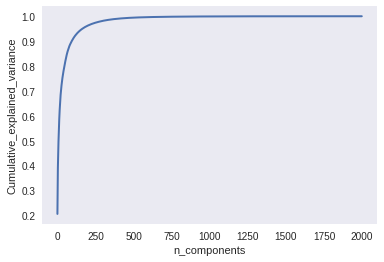

In [30]:
svd = TruncatedSVD(n_components=1999)
svd.fit_transform(matrix)

percentage_var_explained = svd.explained_variance_ratio_ / np.sum(svd.explained_variance_ratio_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the SVD spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

### From Elbow-Knee method the number of retained dimensions should be 250.

In [0]:
svd = TruncatedSVD(n_components=250)
cooc_decomposed=svd.fit_transform(matrix)


### [5.4] Applying k-means clustering

In [32]:
inertia = []
k = []
for i in tqdm(range(50)):
  if i != 0:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1).fit(cooc_decomposed)
    inertia.append(kmeans.inertia_)
    k.append(i)

100%|██████████| 50/50 [00:32<00:00,  1.15s/it]


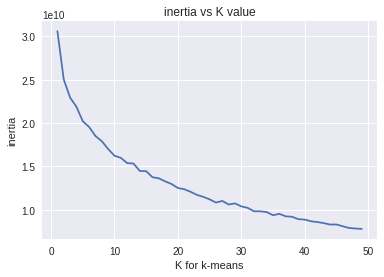

In [33]:
plt.plot(k, inertia)
plt.title('inertia vs K value')
plt.ylabel('inertia')
plt.xlabel('K for k-means')
plt.show()

### From the above graph we can infer that the right value for K must be 8, now getting the silhouette_score.

In [34]:
clusterer = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
cluster_labels = clusterer.fit_predict(cooc_decomposed)
silhouette_avg = silhouette_score(cooc_decomposed, cluster_labels)
print("For n_clusters =", 8, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 8 The average silhouette_score is : 0.849389810366745


### Now visualizing the clusters in 2-D and 3-D.

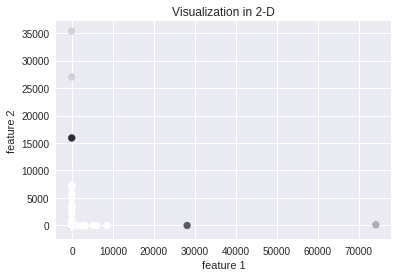

In [35]:
pca = PCA(n_components=2).fit(cooc_decomposed)
pca_2d = pca.transform(cooc_decomposed)
kmeans = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
kmeans.fit(cooc_decomposed)
plt.figure()
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
plt.title('Visualization in 2-D')
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.show()

In [36]:
k_means = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
k_means.fit(cooc_decomposed)
k_means_predicted = k_means.predict(cooc_decomposed)
centroids = k_means.cluster_centers_
X = cooc_decomposed
y = k_means.labels_
print(X.shape)
print(y.shape)


(2000, 250)
(2000,)


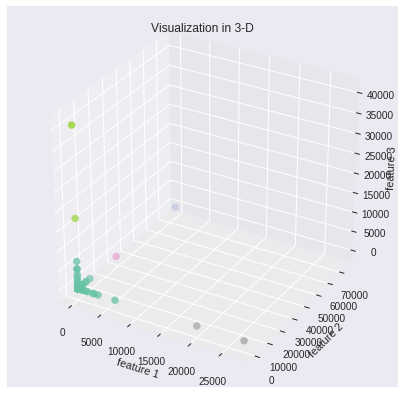

In [37]:
%matplotlib inline

#colors = ['navy', 'turquoise', 'darkorange']
plt.figure('K-Means on given Dataset', figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter(X[:,3],X[:,0],X[:,2], c=y , cmap='Set2', s=50)
plt.title('Visualization in 3-D')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')
plt.show()

### [5.5] Wordclouds of clusters obtained in the above section

In [0]:
def Word_Cloud(X, number_of_clusters):
  model = KMeans(n_clusters=number_of_clusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
  model.fit(X)
  labels = list(model.labels_)
  print('Printing the Word Cloud for all clusters')
  print()
  for x in range(0, 8):
    def lists(x, labels):
      cluster = []
      for i in range(0, len(labels)):
        if labels[i]==x:
          cluster.append(i)
      return cluster
    datapoint_index = lists(x, labels)
    
    list_of_words = []
    for j in datapoint_index:
      for sent in preprocessed_reviews[j].split(' '):
        list_of_words.append(sent)
    print('Cluster'+' '+str(x+1))
    features_str = ' '.join(list_of_words)
    wordcloud = WordCloud(width = 1000, height = 500).generate(features_str)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    #plt.savefig("tfidf_RF"+".png", bbox_inches='tight')
    plt.show()
    plt.close()

Printing the Word Cloud for all clusters

Cluster 1


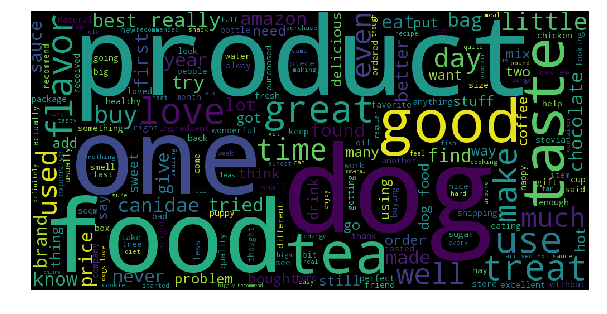

Cluster 2


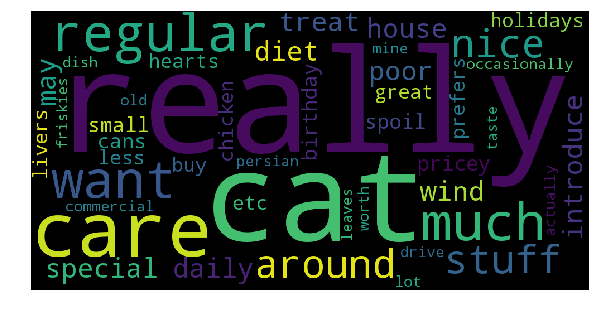

Cluster 3


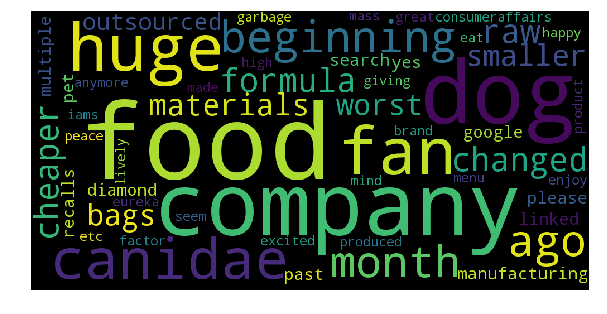

Cluster 4


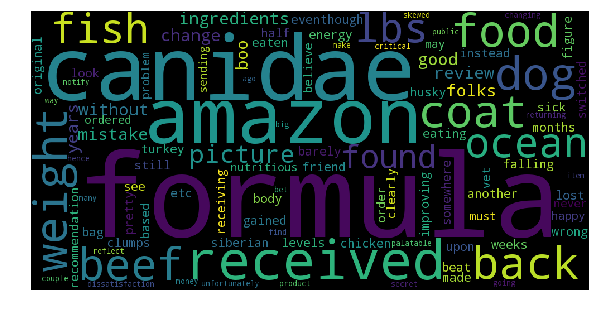

Cluster 5


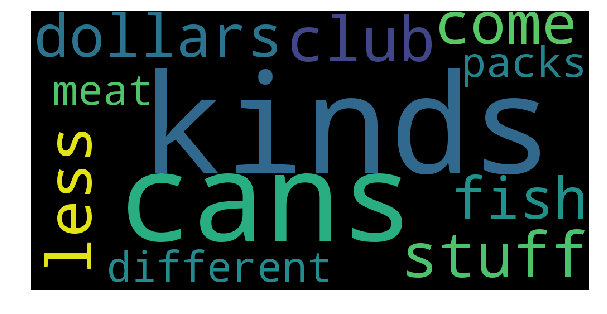

Cluster 6


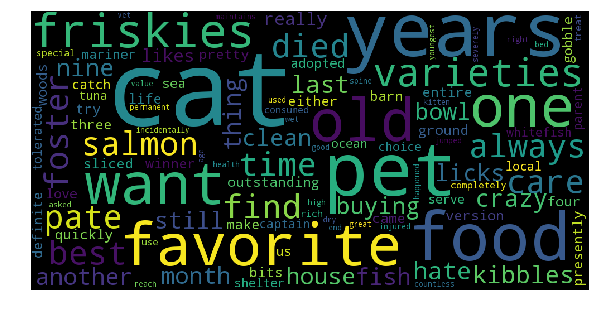

Cluster 7


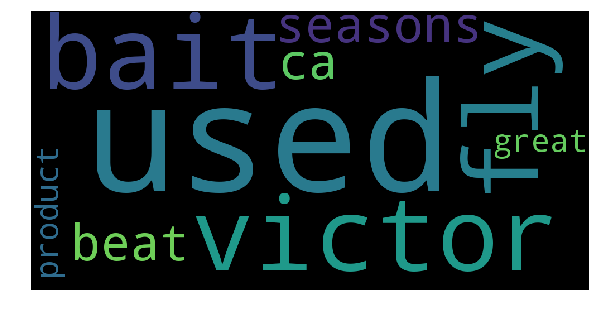

Cluster 8


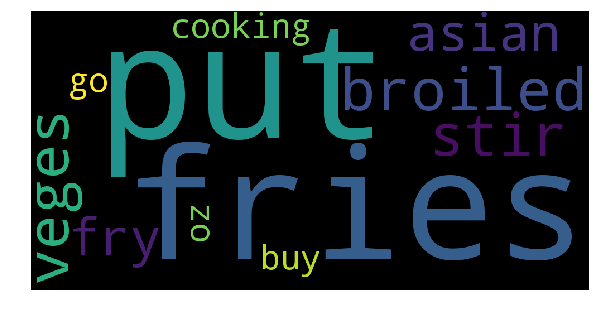

In [39]:
Word_Cloud(cooc_decomposed, 8)

### [5.6] Function that returns most similar words for a given word.

In [0]:
from numpy.linalg import norm
def cos_dis(u,v):
    dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))
    return dist

In [0]:
##Function to print 5 similar word to a given word.
def similar_words(word):
  word_number = corpus.index(word)
  sorted_list = sorted(corpus, key = lambda i: cos_dis(matrix[word_number,:],matrix[corpus.index(i),:]))
  print('The five most similar words of {} are {}'.format(word, str(sorted_list[1:6])))
  #return sorted_list[1:6]

In [44]:
similar_words('product')

The five most similar words of product are ['china', 'chicken', 'loves', 'wont', 'dogs']


# [6] Conclusions

### The number of clusters for k-means clustering is 8 and number of optimal components for co-occurence matrix is 250.